In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Data/insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


# Hypothesis Testing

## Q1. Do smokers have higher insurance charges than non-smokers?
- Null Hypothesis: Insurance charges are the same for smokers and non-smokers
- Alternative Hypothesis: There is a significant difference in insurance charges for smokers and non-smokers.

Based upon the Choosing the Right Hypothesis Test work flow from the LP:
- The appropriate test to perform would be:
    - Since we are measuring a numeric quantity (funded_amount)
    - And we are comparing 2 groups/samples
    - We therefore want to perform a 2-sample test, aka, an independent t-test
- According to the work flow, the 2-sample T-Test has the following assumptions:
    - No significant outliers
    - Normality
    - Equal Variance
    

### Check for outliers

In [3]:
#see how many smokers and nonsmokers
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [4]:
#Filter out smokers and nonsmokers
smokers_df = df.loc[df['smoker']=='yes'].copy()
nonsmokers_df = df.loc[df['smoker']=='no'].copy()

In [5]:
#define feature of interest
smokers_group = smokers_df['charges']
nonsmokers_group = nonsmokers_df['charges']

In [6]:
#Check for outliers in charges for smokers group
zscores = stats.zscore(smokers_group)
outliers = abs(zscores)>3
np.sum(outliers)

0

In [7]:
#Check for outliers in charges for nonsmokers
zscores = stats.zscore(nonsmokers_group)
outliers = abs(zscores)>3
np.sum(outliers)

24

### Check for Normality

In [8]:
result_smokers = stats.normaltest(smokers_group)
result_smokers

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [9]:
result_nonsmokers = stats.normaltest(nonsmokers_group)
result_nonsmokers

NormaltestResult(statistic=316.4528082392722, pvalue=1.9193129759002216e-69)

- Our p-values for both groups are well below 0.05, which means our data is NOT normally distributed.  However, our sample size is large enough to proceed without satisfying this test.  For an independent t-test, sample sizes of 15 per group are considered sufficient.

In [10]:
# Test for equal variance
result = stats.levene(smokers_group, nonsmokers_group)
result

LeveneResult(statistic=332.6135162726081, pvalue=1.5593284881803726e-66)

In [11]:
result = stats.ttest_ind(smokers_group, nonsmokers_group, equal_var=False)
print(result)
result.pvalue<.05

Ttest_indResult(statistic=32.751887766341824, pvalue=5.88946444671698e-103)


True

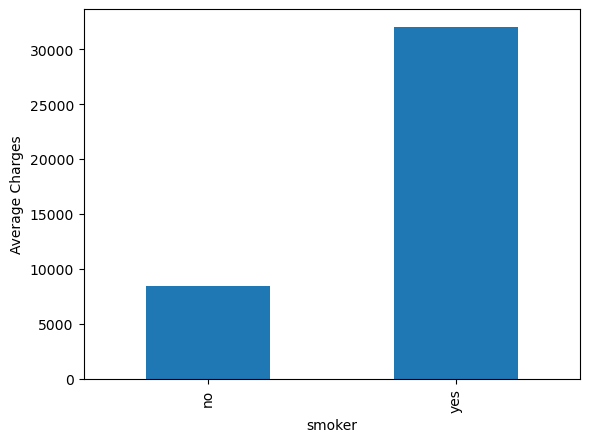

In [32]:
df.groupby('smoker')['charges'].mean().plot(kind='bar')
plt.ylabel('Average Charges');

### Final Conclusion
- Our Welch's T-Test returned a pvalue<.05, so we reject the null hypothesis and support the alternative hypothesis that there is a significant difference in charges for smokers and nonsmokers
- In order to know if charges are significantly MORE or LESS, we look at the actual means of our final groups.

In [12]:
print(f"The average charge for smokers was {smokers_group.mean():.2f}")
print(f"The average charge for nonsmokers was {nonsmokers_group.mean():2f}")

The average charge for smokers was 32050.23
The average charge for nonsmokers was 8434.268298


- Smokers are charged significantly higher than nonsmokers.

## Q2. Are men more likely to smoke than women?
- Null Hypothesis: The likelihood of men smoking is the same as women.
- Alternative Hypothesis: There is a significant difference in the likelihood of men and women smoking.

Based upon the Choosing the Right Hypothesis Test work flow from the LP:
- The appropriate test to perform would be:
    - Since we are measuring categorical
    - And we are comparing 2 groups/samples
    - We therefore want to perform a chi-square test
- According to the work flow, the chi-square test has the following assumptions:
    - There are two categorical variables (nominal)
    - The outcomes are independent.

In [13]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [14]:
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result

In [15]:
# What was our p-value?
print(p)
p<.05

0.006548143503580696


True

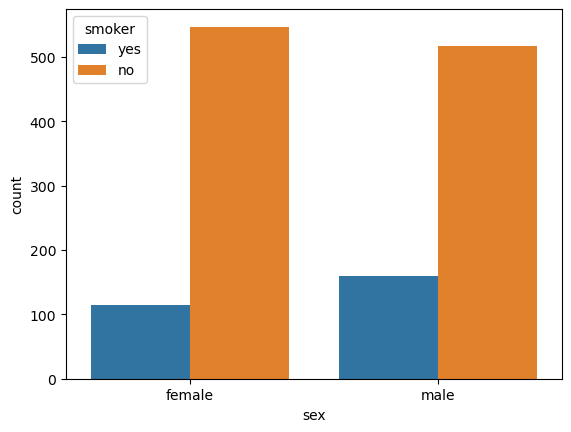

In [16]:
#visualizing means
ax = sns.countplot(data=df, x='sex', hue='smoker')

## Final Conclusion

Since our p < .05, we reject the null hypothesis that there is no relationship between a passenger's Sex and if they smoke.

This means that we accept the alternate hypothesis and conclude that there is a relationship in the likelihood of men and women being a smoker.

## Q3. Do different regions have different charges, on average?

- Null Hypothesis: Different regions do not have different charges, on average.
- Alternative Hypothesis: There is a significant difference in charges in different regions, on average.

Based upon the Choosing the Right Hypothesis Test work flow from the LP:
- The appropriate test to perform would be:
    - Since we are measuring numerical quantity
    - And we are comparing more than 2 groups/samples
    - We therefore want to perform an anova/tukey test
- According to the work flow, the chi-square test has the following assumptions:
    - No significant outliers
    - Equal variance
    - Normality

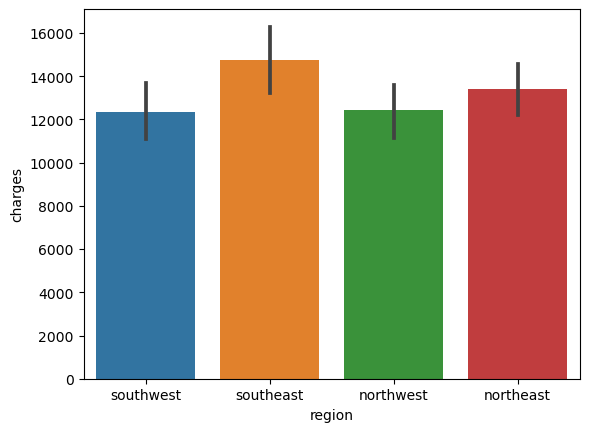

In [17]:
#visualizing means
ax = sns.barplot(data=df, x='region', y = 'charges')

In [18]:
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [19]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [20]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


In [21]:
# with the * operator 
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

In [22]:
# perform the correct hypothesis test
# note again the use of the * operator for convenience
result = stats.kruskal(*groups.values())

result

KruskalResult(statistic=4.734181215658743, pvalue=0.19232908072121002)

In [23]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
## save the values as kg_lost and the labels to the Diet
values = df['charges']
labels = df['region']

In [24]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


## Final Conclusion
The Tukey test showed that there is a significant difference in charges for the Southeast. The charges are significantly higher for those in the Southeast.
We will reject the null hypothesis that there is no difference in charges in different regions. We accept the alternative hypothesis that there is a difference in charges in different regions.